## Data Retrieval

In [1]:
# %pip install google-cloud-bigquery
# %pip install db-dtypes
# %pip install google-cloud-bigquery-storage
# %pip install pandas-gbq

In [2]:
from pandas_gbq import read_gbq
from google.oauth2 import service_account

In [3]:
#Get df from BigQuery
creds = service_account.Credentials.from_service_account_file("car-resale-capstone-81cd3a4d7939.json")
proj_id="car-resale-capstone"

# For ML Data (Blank Cells filled with Assumptions)
ml_df = read_gbq(
    "SELECT * FROM `car-resale-capstone.car_resale_bigquery.final_ml_data`",
    project_id=proj_id,
    credentials=creds,
)
print(ml_df.head())
#print(ml_df.dtypes)

Downloading: 100%|██████████|
                                                 URL          Brand  \
0  https://carro.co/sg/en/cars/kia/cerato/kia-cer...            Kia   
1  https://carro.co/sg/en/cars/honda/civic/honda-...          Honda   
2  https://www.motorist.sg/used-car/10253/mercede...  Mercedes-Benz   
3  https://www.motorist.sg/used-car/10202/honda-s...          Honda   
4  https://www.motorist.sg/used-car/10197/honda-c...          Honda   

                            Make     Price Registration_Date   Sold  \
0                 Cerato 1.6A EX   93888.0        2020-09-24   True   
1  Civic 1.5A VTEC Turbo Sunroof   83888.0        2017-07-18   True   
2                           280S   59800.0        1978-08-31   True   
3                    S2000 2.2 M  102800.0        2008-09-24   True   
4             CIVIC TYPE-R 2.0 M   99800.0        2009-12-23  False   

   Number_of_Previous_Owners  Mileage_km  Previous_COE      OMV  ...  \
0                          1       46268    

In [4]:
ml_df.columns

Index(['URL', 'Brand', 'Make', 'Price', 'Registration_Date', 'Sold',
       'Number_of_Previous_Owners', 'Mileage_km', 'Previous_COE', 'OMV',
       'Road_Tax_Payable', 'COE_Expiry_Date', 'Transmission', 'Fuel_Type',
       'Engine_Capacity_cc', 'Horse_Power_kW', 'Scrape_Date', 'Posted_Date',
       'Vehicle_Age_Years', 'Vehicle_Age_Days', 'COE_Left_Days',
       'COE_Category', 'COE_Cycles', 'COE_Renewed', 'Stocks_Monthly_Avg',
       'Quota_Current_COE', 'Bids_Success_Current_COE',
       'Bids_Received_Current_COE', 'Premium_Current_COE',
       'Previous_COE_Per_Month_Remaining', 'Current_COE_Per_Month_Remaining',
       'Five_Year_COE', 'Classic_Car', 'Website'],
      dtype='object')

In [29]:
len(ml_df.columns)

34

## Preprocessing

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [6]:
# not very useful in predictions, or correlated with other columns
drop_cols = ["URL", "Posted_Date", "Registration_Date", "COE_Expiry_Date", "Scrape_Date", "Sold"] 
data = ml_df.drop(drop_cols, axis=1)

In [7]:
ml_df['Make'].unique

<bound method Series.unique of 0                       Cerato 1.6A EX
1        Civic 1.5A VTEC Turbo Sunroof
2                                 280S
3                          S2000 2.2 M
4                   CIVIC TYPE-R 2.0 M
                     ...              
24783                Aceman Electric E
24784             Model 3 Electric RWD
24785             Model 3 Electric RWD
24786             Model 3 Electric RWD
24787                      T3 Electric
Name: Make, Length: 24788, dtype: object>

In [8]:
len(ml_df)

24788

In [9]:
data["Make3"] = (
    data["Make"]
    .fillna("")
    .astype(str)
    .str.split()
    .str[:3]
    .str.join(" ")
    .str.strip()
    .replace("", np.nan)
)
data = data.drop(columns=["Make"])

In [10]:
X = data.drop(columns='Price')
y = data['Price']

In [11]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

In [12]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [16]:
lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Number_of_Previous_Owners',
                                                   'Mileage_km', 'Previous_COE',
                                                   'OMV', 'Road_Tax_Payable',
                                                   'Engine_Capacity_cc',
                                                   'Horse_Power_kW',
                                                   'Vehicle_Age_Years',
                                                   'Vehicle_Age_Days',
                                                   'COE_Left_Days',
                                                   'COE_Cycles',
                                                   'Stocks_Monthly_Avg',
                                                   'Quota_Current_COE',
                                                   'Bid...
                                                   'Bids_Received_Current_COE',
                                                   'Premium_Current_COE',
                                                   'Previous_COE_Per_Month_Remaining',
                                                   'Current_COE_Per_Month_Remaining']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Brand', 'Transmission',
                                                   'Fuel_Type', 'COE_Category',
                                                   'COE_Renewed',
                                                   'Five_Year_COE',
                                                   'Classic_Car', 'Website',
                                                   'Make3'])])),
                ('regressor', LinearRegression())])

In [17]:
y_pred_lr = lr.predict(X_test)

r2 = r2_score(y_test, y_pred_lr)
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mape = (abs((y_test - y_pred_lr) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4}%")

R²: 0.8837
MAE: 19310.6146
RMSE: 52605.4715
MAPE: 22.92%


### Visualization of Linear Regression

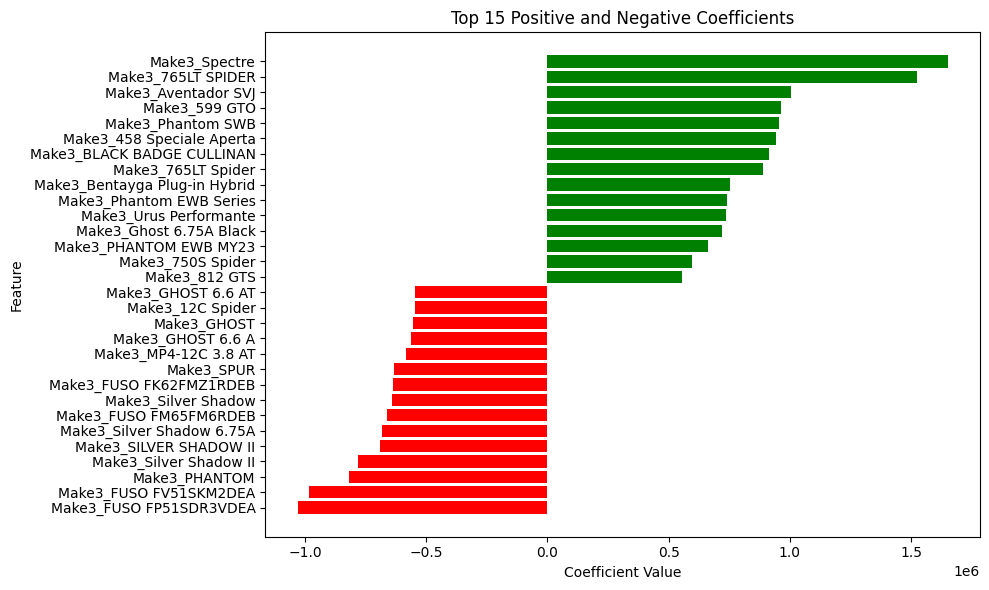

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

NUM = 15

# Get feature names after preprocessing
num_features = numerical_cols
cat_features = lr.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

# Get coefficients
coefs = lr.named_steps['regressor'].coef_

# Create DataFrame
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Select top and bottom 10 for visualization
top_features = pd.concat([coef_df.head(NUM), coef_df.tail(NUM)])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=np.where(top_features['Coefficient'] > 0, 'green', 'red'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Positive and Negative Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [19]:
# After fitting:
lr.fit(X_train, y_train)

# Get the trained linear regression model (the final step of the Pipeline)
reg = lr.named_steps['regressor']

# Get the preprocessor to extract feature names after transformation
pre = lr.named_steps['preprocessor']

# Get names of transformed features
feature_names = pre.get_feature_names_out()

# Get coefficients (one per transformed feature)
coefficients = reg.coef_

# Build DataFrame of coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by coefficient
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=True)


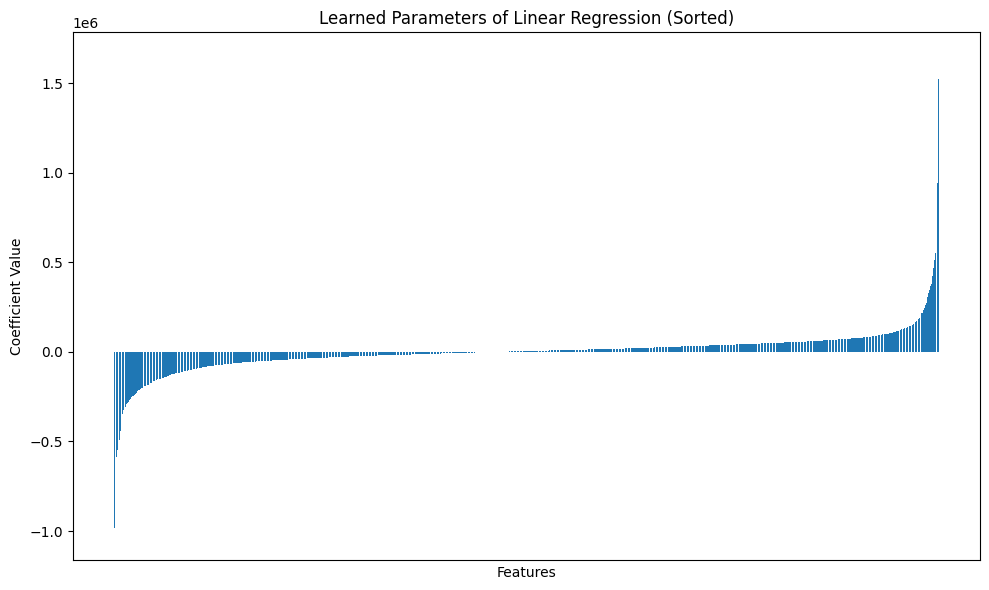

In [20]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients_df)), coefficients_df['Coefficient'])
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.title("Learned Parameters of Linear Regression (Sorted)")
plt.xticks([]) 
plt.tight_layout()
plt.show()


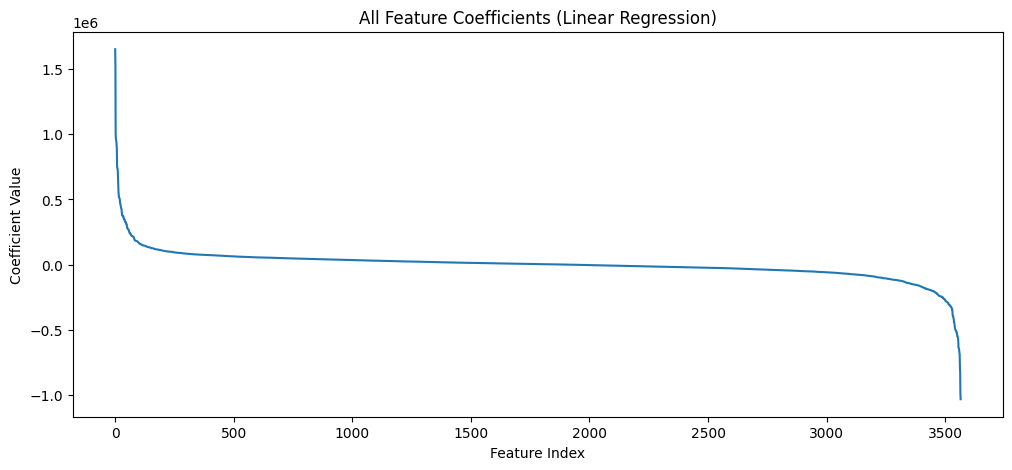

In [21]:
# too many features to be a bar plot due to all the make3 one-hot encoding
plt.figure(figsize=(12, 5))
plt.plot(coef_df['Coefficient'].values)
plt.title('All Feature Coefficients (Linear Regression)')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.show()

In [22]:
print("Train R² (Linear):", lr.score(X_train, y_train))
print("Test R² (Linear):", lr.score(X_test, y_test))

Train R² (Linear): 0.9647217382397985
Test R² (Linear): 0.8837462503915294


since train r2 >> test r2, model is overfitting

## Lasso Regression

In [23]:
from sklearn.linear_model import LassoCV

In [24]:
lasso_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, random_state=42))
])

In [25]:
lasso_cv.fit(X_train, y_train)
print("Best alpha:", lasso_cv.named_steps['regressor'].alpha_)

Best alpha: 136.74842242265885


In [26]:
y_pred_lasso = lasso_cv.predict(X_test)

r2 = r2_score(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mape = (abs((y_test - y_pred_lasso) / y_test).mean()) * 100

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4}%")

R²: 0.8037
MAE: 32033.2777
RMSE: 68362.3766
MAPE: 40.18%


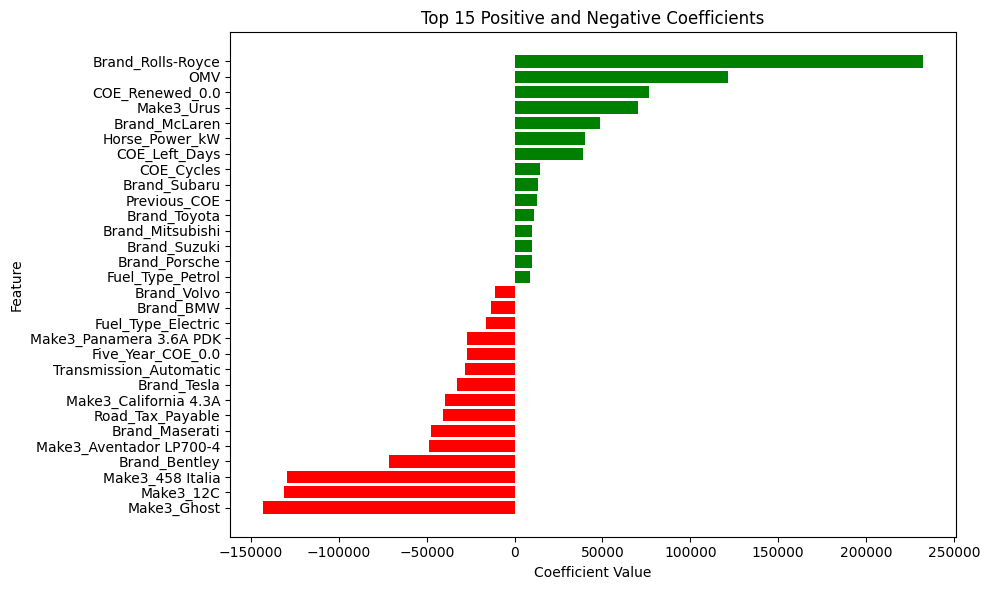

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

NUM = 15

# Get feature names after preprocessing
num_features = numerical_cols
cat_features = lasso_cv.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([num_features, cat_features])

# Get coefficients
coefs = lasso_cv.named_steps['regressor'].coef_

# Create DataFrame
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': coefs})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Select top and bottom 10 for visualization
top_features = pd.concat([coef_df.head(NUM), coef_df.tail(NUM)])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=np.where(top_features['Coefficient'] > 0, 'green', 'red'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {NUM} Positive and Negative Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


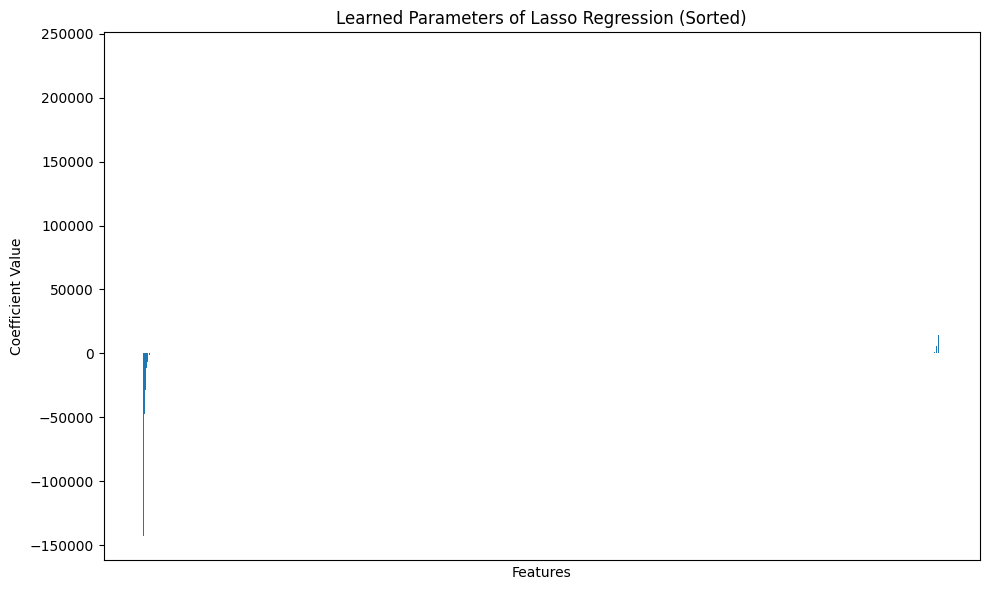

In [28]:
# After fitting:
lasso_cv.fit(X_train, y_train)

# Get the trained linear regression model (the final step of the Pipeline)
reg = lasso_cv.named_steps['regressor']

# Get the preprocessor to extract feature names after transformation
pre = lasso_cv.named_steps['preprocessor']

# Get names of transformed features
feature_names = pre.get_feature_names_out()

# Get coefficients (one per transformed feature)
coefficients = reg.coef_

# Build DataFrame of coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by coefficient
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients_df)), coefficients_df['Coefficient'])
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.title("Learned Parameters of Lasso Regression (Sorted)")
plt.xticks([]) 
plt.tight_layout()
plt.show()


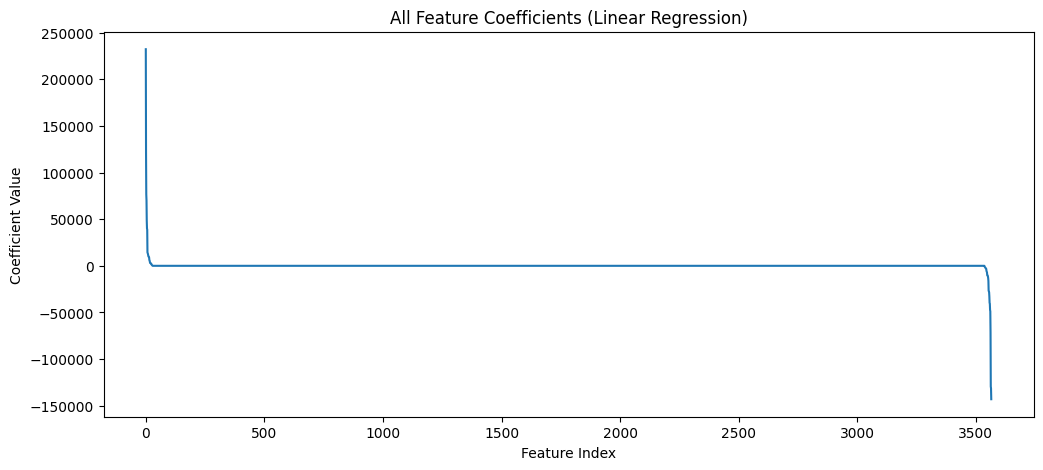

In [28]:
# too many features to be a bar plot due to all the make3 one-hot encoding
plt.figure(figsize=(12, 5))
plt.plot(coef_df['Coefficient'].values)
plt.title('All Feature Coefficients (Linear Regression)')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.show()

In [29]:
print("Train R² (Lasso):", lasso_cv.score(X_train, y_train))
print("Test R² (Lasso):", lasso_cv.score(X_test, y_test))

Train R² (Lasso): 0.8320781073251025
Test R² (Lasso): 0.8036732675493758


although r2 is lower, better generalization and interpretability as train and test r2 are close (more stable)